# Data exploration Liège

The purpose of this document is to determine which kind of information could be mined from textual data of citizen opinion. The data sources are the following :
- Reinventons Liège : Result of an e-participation program conducted by the city of Liège
- Liège 2025: The on going e-participation program of the city of Liège
- Facebook
- Twitter



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import twitter
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import unidecode
import glob
import re 
import string
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sklearn.manifold import TSNE 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

DATA_FOLDER = "./data"

# Twitter Mining

We use the standard twitter API to retrieve tweets. I allows us to search and retrieves tweets published in the past 7 days. The search query choosed is the following:
- The tweet must contains the word "liege"
- The language used must be french
- The tweet must be send from the city of Liège

We loop on the request in order to retrieve as much tweets as possible

In [2]:
with open('./creds/creds_twitter.json') as fp:
    creds_twitter = json.load(fp)

api = twitter.Api(consumer_key=creds_twitter["consumer_key"],
                  consumer_secret=creds_twitter["consumer_secret"],
                  access_token_key=creds_twitter["access_token_key"],
                  access_token_secret=creds_twitter["access_token_secret"])

print(api.VerifyCredentials())

{"created_at": "Tue Jun 21 16:55:04 +0000 2011", "description": "PhD student UNamur: AI, Machine Learning, Gesture recognition.\n\nskeptical and transhumanist", "favourites_count": 1367, "followers_count": 134, "friends_count": 559, "geo_enabled": true, "id": 321478422, "id_str": "321478422", "listed_count": 3, "location": "verviers", "name": "jef", "profile_background_color": "000000", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "profile_banner_url": "https://pbs.twimg.com/profile_banners/321478422/1353778277", "profile_image_url": "http://pbs.twimg.com/profile_images/1215588828364316672/bZDAcnSz_normal.jpg", "profile_image_url_https": "https://pbs.twimg.com/profile_images/1215588828364316672/bZDAcnSz_normal.jpg", "profile_link_color": "91D2FA", "profile_sidebar_border_color": "000000", "profile_sidebar_fill_color": "000000", "profile_text_color": "000000"

In [6]:
# Retrieving 1000 tweets
results = api.GetSearch(
    raw_query="q=Liege%20&result_type=recent&lang=fr&geocode=50.6331%2C5.57134%2C10km&tweet_mode=extended&count=100", return_json=True)

tweets = results["statuses"]
for i in range(0,60):
    last_id = tweets[-1]["id"]
    
    query = "q=Liege%20&result_type=recent&lang=fr&geocode=50.6331%2C5.57134%2C10km&count=100&tweet_mode=extended&max_id={}".format(last_id)
    results = api.GetSearch(
        raw_query=query, return_json=True)
    tweets += results["statuses"]

# Saving data : 
timestr = time.strftime("%Y%m%d-%H%M%S")
path = "{}/tweets-{}.json".format(DATA_FOLDER, timestr)
with open(path, "w") as fp:
    json.dump(tweets, fp)
    
print(len(tweets))

662


In [7]:
# Test trends
import tweepy

auth = tweepy.OAuthHandler(creds_twitter["consumer_key"], creds_twitter["consumer_secret"])
auth.set_access_token(creds_twitter["access_token_key"], creds_twitter["access_token_secret"])

api = tweepy.API(auth)

print(api.trends_place("23424757"))

ModuleNotFoundError: No module named 'tweepy'

In [8]:
# Load all retrieved tweets and remove duplicates
tweets = []
path = "{}/{}".format(DATA_FOLDER, "tweets-*.json")
tweet_files = glob.glob(path)

for file in tweet_files:
    with open(file) as fp:
        tweets += json.load(fp)

tweets = list({v['id']:v for v in tweets}.values())
print(len(tweets))

# Filterint RT
without_RT = []
for elem in tweets:
    if not elem["full_text"].startswith('RT @'):
        without_RT.append(elem)
        
print(len(without_RT))

i = 0
more_than_100 = []
for elem in without_RT:
    if len(elem["full_text"]) > 100:
        more_than_100.append(elem)
        i +=1
        
print(i)
without_RT = more_than_100

6005
3344
1962


## Who tweets and when ?

First action is to identify which twitters account are the most represented in the dataset. We take the top 10 users in the corpus. The account identified are the following :
- La Meuse Liège : Account of a local newspaper
- moncoeur1971 : Retweet news articles mentionning Liege or talking about a global event
- Live From Liege : Owned by a citizen of Liege. Retweets and comment various information about the city
- RFC liege : Unofficial account of Liege's football club. 
- LaMeuse.be : A Belgian Newspaper
- Patrice Lempereur : Politician 
- RFC Liege News : Feed of football news
- Pamina : Bloggers from Liege
- Ilse Flück : Citizen living near Liege
- Verlaine François : Citizen of Liège

Those accounts are responsible of 244 in our dataset containing 715 tweets.

Another graph plots the numbers of tweets by chunk of 2 hours. We can clearly see that the tweets are posted during daytime hour in Belgium. The tweets gathered are, thus, likely written by people living in Belgium.

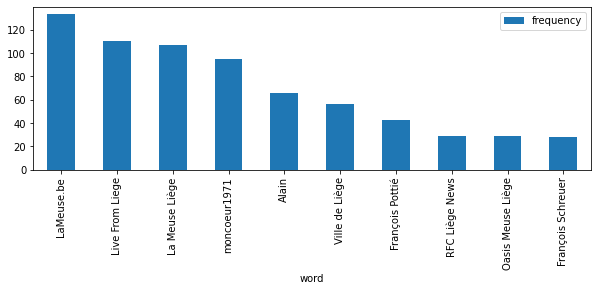

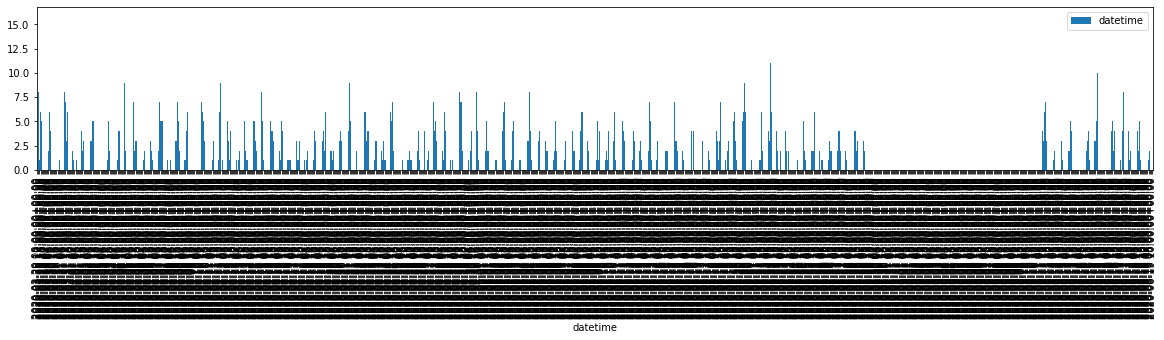

In [5]:
# Who tweets the most :
users = []
created_at = []
for elem in without_RT:
    users.append(elem["user"]["name"])
    ts = elem['created_at']
    created_at.append(ts)
    
c = Counter(users)

df = pd.DataFrame(c.most_common(10), columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize=(10,3))

# Create an empty dataframe
df = pd.DataFrame()
df['datetime'] = created_at
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime'] 

df.resample('2H').count().plot(kind="bar", figsize=(20,3))

## Tweet preprocessing

In order to get the best performance when applying NLP algorithm to our corpus, the following operation are applied to the tweets :
- The smiley are removed
- The characters @ and # are removed
- The links are removed



In [9]:
for i in range(1,10):
    print(without_RT[-i]["full_text"] + "\n")
    

C’est même pas histoire de « Liège ville de merde, etc. » y a ça partout. C’est juste eux. Qu’ils aillent baiser leurs morts. 
Et tout les petits fdp qui s’abonnent à ce compte, vous êtes comme eux, vous leur donner de la force.

@_islagram_ C’est même pas Liège en soit, y a ça partout. Y a deux semaines c’était sur Bx et Paris, des comptes d’affichage. Y avait pas des vidéos de viol mais c’est quand même malsain

Conférence sur les objets gallo-romains en céramique et verre issus d'anciennes fouilles archéologiques dans le cadre de l'exposition "Racines, les civilisations du Bas-Danube" - Europalia Romania le 23/4 à 18h au Grand Curtius.
https://t.co/5DAWV6ytr8 https://t.co/igQVbC8Fat

Du 3e étage, il jette un surmatelas sur les policiers à Liège https://t.co/OtUeWkWDta https://t.co/WDVzuTIGNh

Le procureur du Roi de Liège l’assure: «Aucun p.-v. Covid-19 n’est classé sans suite» au parquet liégeois «et avec 59% de réponse pénale» https://t.co/O7nJwr50sx

@Willy_Demeyer il paraît que l

In [10]:
def remove_tweeter_char(tweet):
    tweeter_char = ["#", "@"]
    return ''.join(filter(lambda x: x not in tweeter_char, tweet))

def remove_links(tweet):
    cleaned = []
    
    for word in re.split(" |\n", tweet):
        if not word.startswith('http'):
            cleaned.append(word)
    return " ".join(cleaned)

def keep_only_ascii(tweet):
    # Remove accent
    unaccented_string = unidecode.unidecode(tweet)
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, unaccented_string))
    
def remove_blank(tweet):
    s = tweet.split()
    return " ".join(s)

def remove_punctuation(tweet):
    punc = [".", ":", "!", "?"]
    return ''.join(filter(lambda x: x not in punc, tweet))


def clean_tweet(tweet, keep_punc=False):
    tweet.replace("&amp;"," ")
    tweet = keep_only_ascii(tweet)
    tweet = tweet.replace("_", " ")
    tweet = remove_links(tweet)
    tweet = remove_tweeter_char(tweet)
    
    if not keep_punc:
        tweet = remove_punctuation(tweet)
    
    return remove_blank(tweet)
for tweet in without_RT:
    tweet["cleaned_text"] = clean_tweet(tweet["full_text"])

In [11]:
for i in range(1,10):
    print(without_RT[-i]["cleaned_text"] + "\n")


C'est meme pas histoire de << Liege ville de merde, etc >> y a ca partout C'est juste eux Qu'ils aillent baiser leurs morts Et tout les petits fdp qui s'abonnent a ce compte, vous etes comme eux, vous leur donner de la force

islagram C'est meme pas Liege en soit, y a ca partout Y a deux semaines c'etait sur Bx et Paris, des comptes d'affichage Y avait pas des videos de viol mais c'est quand meme malsain

Conference sur les objets gallo-romains en ceramique et verre issus d'anciennes fouilles archeologiques dans le cadre de l'exposition "Racines, les civilisations du Bas-Danube" - Europalia Romania le 23/4 a 18h au Grand Curtius

Du 3e etage, il jette un surmatelas sur les policiers a Liege

Le procureur du Roi de Liege l'assure <<Aucun p-v Covid-19 n'est classe sans suite>> au parquet liegeois <<et avec 59% de reponse penale>>

Willy Demeyer il parait que la Vile de Liege va recevoir 20,000 masques de l'etat turc, est-ce vrai

Mon pere, presque 70 ans, presque 40 ans a la tete de son 

In [16]:
# Create a file with gathered tweets
data = []

for elem in without_RT:
    c = elem["created_at"]
    f_t = elem["full_text"]
    c_t = elem["cleaned_text"]
    rt = elem["retweet_count"]
    fav = elem["favorite_count"]
    user = elem["user"]["screen_name"]
    
    data.append((c, f_t, c_t, rt, fav, user))
    
to_save = pd.DataFrame(data, columns =['created_at', 'full_text', "cleaned_text", "retweeted_count", "favorite_count", "user"]) 
to_save.to_csv("./data/all_tweets.csv")

# Feature extraction

That section use the Spacy tokenizer in order to extract information from the tweets. This section showcase the information extracted and how they can be used.

The spacy tokenizer is pre-trained on a french news corpus. It is able to capture relevant information about each word of the sentences allowing us to retrieve the entity cited in the tweets or similarity vector for each words of a tweet.

In [13]:
# Modélisation avec SPACY
nlp = spacy.load("fr_core_news_md")

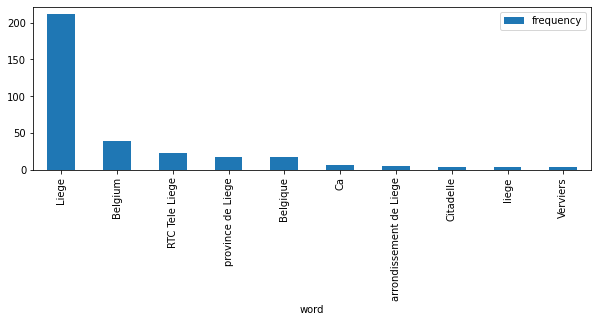

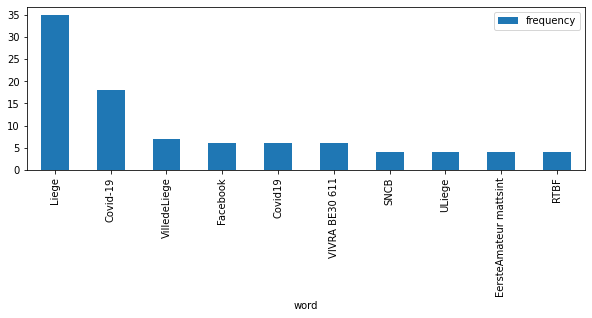

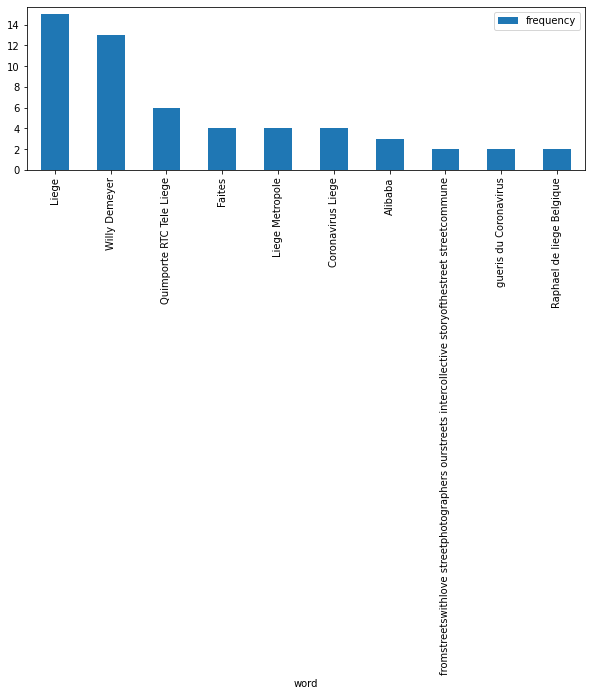

In [14]:
# Retrieving tokenized documents
loc = []
person = []
others = []
all_docs = []
sentiment = []
bleh = []

for tweet in without_RT:
    doc = nlp(tweet["cleaned_text"])
    sentiment.append(doc.sentiment)
    # Sorting
    for ent in doc.ents:
        l = []
        ot = []
        p = []
        
        bleh.append(ent.label_)
        
        if ent.label_ == "LOC":
            l.append(ent.text)
        elif ent.label_ == "PER":
            p.append(ent.text)
        else:
            ot.append(ent.text)
            
    loc += list(set(l))
    others += list(set(ot))
    person += list(set(p))
    all_docs.append(doc)

c = Counter(loc)

df = pd.DataFrame(c.most_common(10), columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize=(10,3))

c = Counter(others)

df = pd.DataFrame(c.most_common(10), columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize=(10,3))


c = Counter(person)

df = pd.DataFrame(c.most_common(10), columns=['word', 'frequency'])
df.plot(kind='bar', x='word', figsize=(10,3))


In [72]:
# https://medium.com/better-programming/the-beginners-guide-to-similarity-matching-using-spacy-782fc2922f7c
# https://towardsdatascience.com/analyzing-tweets-from-the-polemical-pokemon-related-bringbacknationaldex-tag-with-spacy-and-gcloud-661ec0a08a4c


# Clustering with similarity vector

Spacy allows us to retrieve the mean of the word similarity for each sentences. This metrics could be use in an attempt to cluster our tweet in order to, hopefully, end up with relevant classification. However, the spacy similarity vector is based on computation performed to the model level (The french model trained on all the news articles) and not the corpus level (our tweets). The representation may not be suited for our corpus.

In [15]:
# Clustering
X = np.array([x.vector for x in all_docs])

X_embedded = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=3).fit_predict(X)

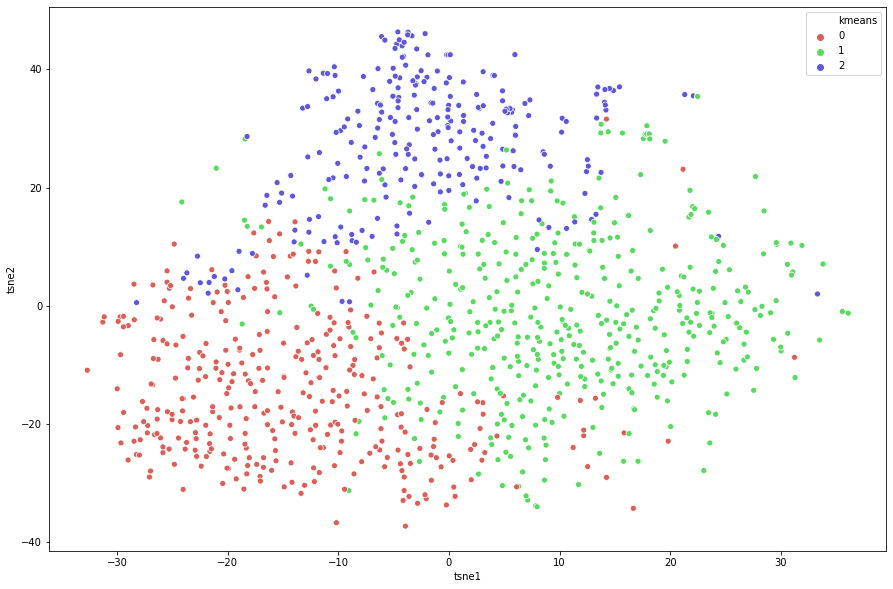

In [16]:
df = pd.DataFrame(X_embedded, columns =['tsne1', 'tsne2'])
df["kmeans"] = kmeans
df["val"] = np.array([x["cleaned_text"] for x in without_RT])

plt.figure(figsize=(15,10))
sns.scatterplot(x = "tsne1", y="tsne2", hue="kmeans", data=df, palette=sns.color_palette("hls", 3))

In [17]:
data = df.sample(frac=0.08)

print("\n\n Categorie 0 \n\n")
for i, row in data.iterrows():
    if row["kmeans"] == 0:
        print(row["val"] + "\n")


print("\n\n Categorie 1 \n\n")
for i, row in data.iterrows():
    if row["kmeans"] == 1:
        print(row["val"] + "\n")
        
        
print("\n\n Categorie 2 \n\n")
for i, row in data.iterrows():
    if row["kmeans"] == 2:
        print(row["val"] + "\n")




 Categorie 0 


adrienhotton CarloDiAntonio J'ai lu ceci, via UrbAgora On y parle de l'importance des decisions wallonnes Les Ravel , c'est bien pour le Dimanche et pour certains Mais c'est loin d'etre le seul vecteur

Le parquet de Liege ne laissera plus rien passer s'en prendre au personnel soignant, c'est desormais tolerance zero via sudpresseonline

Abri de jour rue Morinval Liege a l'instant Aucune SocialDistancing PolicedeLiege Willy Demeyer Respecter les mesures COVID2019

Coup dur pour la cite ardente il n'y aura pas de festivites du 15 aout a Liege cette annee a cause du coronavirus

Flokerica RneleBelge Cause perdue ma Floflo c'est sa passion de critiquer Liege, nos mots et nos traditions []

Quelques photos des rues de Liege pendant le confinement covid19be (c'est pas que ca me fasse plaisir de voir notre ville comme ca, mais je voulais documenter ce moment irreel et j'espere unique A bientot en Cite ardente) &gt;Album photo&gt;&gt;

Meme dans le sud de la France on peut p

# TF-IDF

The TF-IDF algorithm create an encoding for each document of the corpus based on the frequence of a word relatives to its frequence in the overall corpus. I expect to get an encoding allowing an easier clustering as the TF-IDF matrix is trained only on our corpus and not a more general.

In [11]:
documents = np.array([x["cleaned_text"] for x in without_RT])
import nltk
from nltk.cluster.kmeans import KMeansClusterer
from sklearn.feature_extraction.text import CountVectorizer

nbr_cluster = 30

def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

vectorizer = TfidfVectorizer(stop_words=list(fr_stop)+['qu', 'quelqu'])
X = vectorizer.fit_transform(documents)


X_embedded = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=nbr_cluster).fit_predict(X)

# COSINE distance kmean
model = KMeansClusterer(nbr_cluster, nltk.cluster.util.cosine_distance, avoid_empty_clusters = True)
one_hot_vec = [freq.toarray()[0] for freq in X]
co_kmean = model.cluster(one_hot_vec, assign_clusters=True)

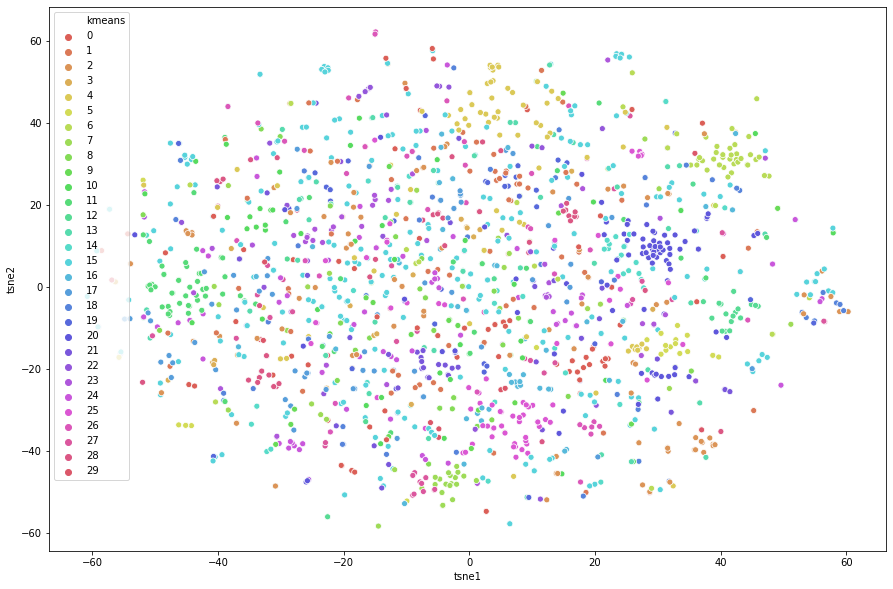

In [12]:

tsne = pd.DataFrame(X_embedded, columns =['tsne1', 'tsne2'])
tsne["kmeans"] = co_kmean
tsne["val"] = documents

plt.figure(figsize=(15,10))
sns.scatterplot(x = "tsne1", y="tsne2", hue="kmeans", data=tsne, palette=sns.color_palette("hls", nbr_cluster))

In [13]:
for i in range(nbr_cluster):
    print("\n\n\n=======================================================")
    print("CLUSTER {}".format(i))
    print("=======================================================\n\n\n")
    
    for j, row in tsne.iterrows():
        if row["kmeans"] == i:
            print(row["val"] + "\n")





CLUSTER 0



VOO liege Basket est heureux d'annoncer la venue de Kevin Stilmant de Spirou Charleroi Poste 5, ne en 2000 et mesure 2m08 Il est aussi passe par Royal Gallia BC Beez, NBC Alsavin Belgrade et le CF AWBB Il evoluera en D1 et dans notre seconde equipe Bienvenu Kevin

Au temps du Coronavirus Message de l'eveque de Liege aux personnes agees pour la fete de Paques, envoye dane toutes les maisons de repos du diocese

Covid-19 une nouvelle technique de l'universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique

Covid-19 une nouvelle technique de l&amp;039;universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique via TodayinliegeBe

Merci qui Merci ULiege Covid-19 une nouvelle technique de l&amp;039;universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique via TodayinliegeBe

Covid-19 une nouvelle technique de l&amp;039;universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique via TodayinliegeBe

Appel 

In [8]:
# Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

text = np.array([x["cleaned_text"] for x in without_RT])

documents = [TaggedDocument(doc.split(" "), [i]) for i, doc in enumerate(text)]
model = Doc2Vec(documents, vector_size=32, window=2, min_count=3, workers=4)

ModuleNotFoundError: No module named 'gensim'

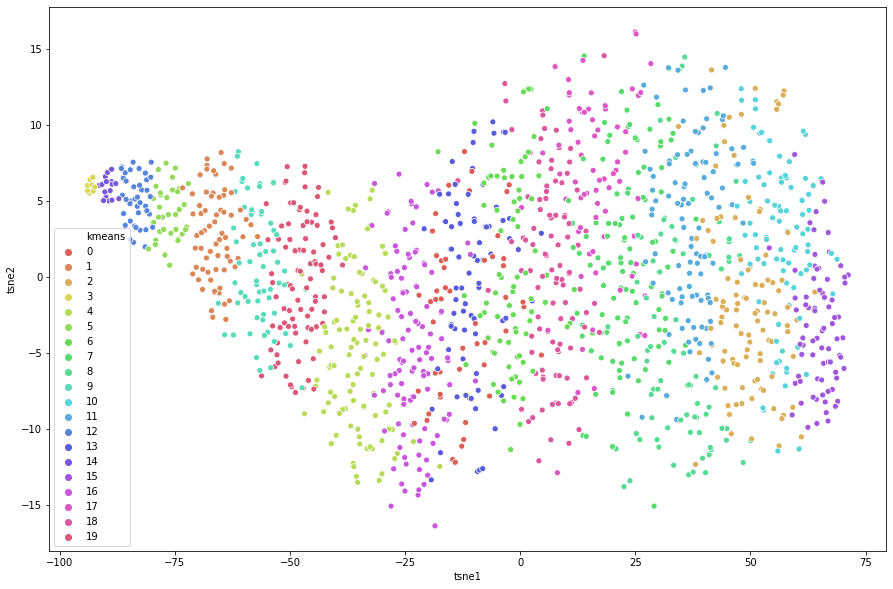

In [15]:
X = [list(model.docvecs[i]) for i in range(len(text))]

X_embedded = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=20).fit_predict(X)

tsne = pd.DataFrame(X_embedded, columns =['tsne1', 'tsne2'])
tsne["kmeans"] = kmeans
tsne["val"] = text

plt.figure(figsize=(15,10))
sns.scatterplot(x = "tsne1", y="tsne2", hue="kmeans", data=tsne, palette=sns.color_palette("hls", 20))

In [ ]:
print("\n\n Categorie 0 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 0:
        print(row["val"] + "\n")


print("\n\n Categorie 1 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 1:
        print(row["val"] + "\n")

        
print("\n\n Categorie 2 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 2:
        print(row["val"] + "\n")
        
print("\n\n Categorie 3 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 3:
        print(row["val"] + "\n")
        

print("\n\n Categorie 4 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 4:
        print(row["val"] + "\n")
        
        
print("\n\n Categorie 5 \n\n")
for i, row in tsne.iterrows():
    if row["kmeans"] == 5:
        print(row["val"] + "\n")

# Facebook Mining

The authentication token was generated on this page : https://developers.facebook.com/tools/explorer
Unfortunatly we cannot retrieve the posts of a facebook page if the admin doesn't authorize the app for the page and if facebook didn't review the app code (group tested : https://www.facebook.com/groups/876630572756781)

In [ ]:
with open('./creds/facebook_token.json') as fp:
    creds_twitter = json.load(fp)

graph_api = facebook.GraphAPI(creds_twitter["access_token"])
group = graph_api.get_object("876630572756781")